# Digits recognition with supervised and unsupervised ML algorithms
### Using "classical" ML algorithms to recognise hand-written digits. 
It is obvious that even with high accuracy, the variance of such a model will be too large. The project aims to see the possibilities of algorithms without the use of deep learning and is a sandbox for various techniques.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict,  cross_val_score
from sklearn.metrics import accuracy_score

# Downloading and analyzing data

In [5]:
#importing MNIST dataset with handwritten digits 

# from sklearn.datasets import fetch_openml
df = fetch_openml("mnist_784", version=1)

# downloading mnist data every time is ineffective, saving them once as a file then reading them is much faster

# with open("data.pickle", "wb") as f:
#     pickle.dump(df, f)

In [4]:
#load data
# with open("data.pickle", "rb") as f:
#     df = pickle.load(f)

In [6]:
#dividing dataset into data and target datasets
X, y = np.array(df["data"]), np.array(df["target"])
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [10]:
#y data are str type, let's transform it
print(type(y[0]))
y = y.astype("uint8")
print(type(y[0]))

<class 'numpy.uint8'>
<class 'numpy.uint8'>


In [11]:
#distribution of the number of digits in a data set
for number in range(10):
    print(f"{number}: {len(y[y==number])/len(y) * 100: .3f}%")
#it seems that dataset is not very skewed, that's good :)

0:  9.861%
1:  11.253%
2:  9.986%
3:  10.201%
4:  9.749%
5:  9.019%
6:  9.823%
7:  10.419%
8:  9.750%
9:  9.940%


In [12]:
#checking if there are nan values
print(np.isnan(X).sum())
print(np.isnan(y).sum())

0
0


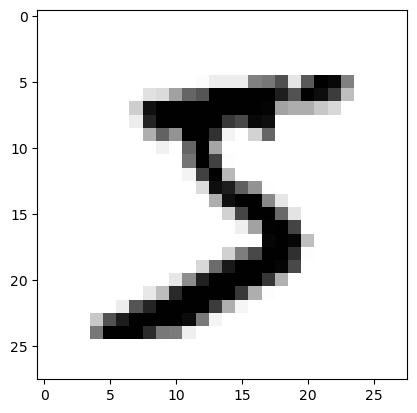

In [13]:
#showing sample image of number
plt.imshow(X[0].reshape(28,28), cmap = "binary")
plt.show()

In [14]:
#splitting datasets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1/7, random_state=42)

# Building model

In [13]:
#at first it would be a good idea to find the most promising model
knn_clf = KNeighborsClassifier()
sgd_clf = SGDClassifier()
rfg_clf = RandomForestClassifier()

print("knn model accuracy:", cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy"))
print("sgd model accuracy:", cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print("rfg model accuracy:", cross_val_score(rfg_clf, X_train, y_train, cv=3, scoring="accuracy"))

knn model accuracy: [0.9673  0.96945 0.96735]
sgd model accuracy: [0.8614  0.88205 0.8757 ]
rfg model accuracy: [0.9658  0.96815 0.96545]


In [12]:
#the knn model seems to be the most promising, let's tune the hyperparameters
#building pipeline 
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", KNeighborsClassifier()),
])

params= {}
# params["scaler"] = [Normalizer(), StandardScaler(), MinMaxScaler()] 
params["scaler"] = [Normalizer()] 
params["classifier"] = [KNeighborsClassifier()]
params["classifier__n_neighbors"] = [3, 5, 7]

print(params)


grid = GridSearchCV(pipeline, params, cv=3, scoring = "accuracy", n_jobs=-1)

{'scaler': [Normalizer()], 'classifier': [KNeighborsClassifier()], 'classifier__n_neighbors': [3, 5, 7]}


In [13]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'classifier': [KNeighborsClassifier(n_neighbors=3)],
                         'classifier__n_neighbors': [3, 5, 7],
                         'scaler': [Normalizer()]},
             scoring='accuracy')

In [14]:
evaluation = pd.DataFrame(data=grid.cv_results_)
evaluation

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_neighbors,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.963287,0.244737,311.222089,22.211935,KNeighborsClassifier(n_neighbors=3),3,Normalizer(),{'classifier': KNeighborsClassifier(n_neighbor...,0.97415,0.9752,0.9727,0.974017,0.001025,1
1,5.523836,2.353290,324.330310,4.107602,KNeighborsClassifier(n_neighbors=3),5,Normalizer(),{'classifier': KNeighborsClassifier(n_neighbor...,0.97330,0.9744,0.9719,0.973200,0.001023,2
2,4.222510,2.090952,243.561232,93.925578,KNeighborsClassifier(n_neighbors=3),7,Normalizer(),{'classifier': KNeighborsClassifier(n_neighbor...,0.97150,0.9723,0.9712,0.971667,0.000464,3


In [15]:
# after a long time of calculations the best hyperparameters are as follows:
print(f"best estimator: {grid.best_estimator_}")
print(f"best params: {grid.best_params_}")
print(f"best accuracy: {grid.best_score_: .3f}%")


best estimator: Pipeline(steps=[('scaler', Normalizer()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])
best params: {'classifier': KNeighborsClassifier(n_neighbors=3), 'classifier__n_neighbors': 3, 'scaler': Normalizer()}
best accuracy:  0.974%


In [15]:
# training the final model on the entire data set
model = Pipeline([
    ("scaler", Normalizer()),
    ("classifier", KNeighborsClassifier(n_neighbors=3)),
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', Normalizer()),
                ('classifier', KNeighborsClassifier(n_neighbors=3))])

In [16]:
# applying the model to the test set and see the accuracy of final model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_pred)}%")


accuracy: 0.9767%


In [17]:
#saving model
with open("model.pickle", "wb") as f:
    pickle.dump(model, f)

### Not bad! But let's try to improve the model with more advanced techniques

# Dimensionality reduction

In [23]:
#When we look at the digits in the dataset, we see that most of the plot is actually white pixels
#let's visualize it better with random forest algorithm
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
#quick look at accuracy
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9674

In [25]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = "hot",
               interpolation="nearest")
    plt.axis("off")

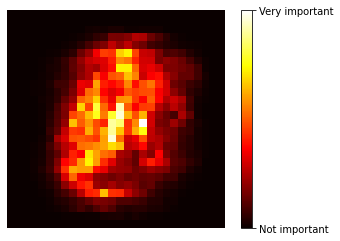

In [26]:
plot_digit(rnd_clf.feature_importances_)

heatmap = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
heatmap.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [27]:
#the sides of the photo have practically no effect on the accuracy of the algorithm
#Maybe PCA will reduce number of features and boost learning of the model? Let's try
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [31]:
X_reduced[0].shape

(154,)

In [32]:
#Looks like PCA reduced number of dimension to only 154! That's muuuch less than 784
#but what with accuracy?
rnd_clf.fit(X_reduced, y_train)

RandomForestClassifier(random_state=42)

In [36]:
#fast look on the accuracy
y_pred = rnd_clf.predict(pca.transform(X_test))
accuracy_score(y_test, y_pred)

0.9469

In [ ]:
#well...I expected much better result, but I don't give up :)

# Clustering

In [39]:
# Sometimes clustering is good in preprocessing data, let's see
from sklearn.cluster import KMeans
pipe = Pipeline([
    ("kmeans", KMeans(n_clusters = 200)),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=200)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [40]:
pipe.score(X_test, y_test)

0.9444

In [ ]:
#again there is no improvment

# Ensemble learning

In [44]:
# one of the most powerful (and my favourites) algorithms is XGBoost, let's see how it will perform
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()

params = [
 dict(
    max_depth=[2,4,6],           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests    
 )]
grid = GridSearchCV(xgb_clf, params, cv=3, scoring = "accuracy", n_jobs=5)

In [45]:
grid.fit(X_train, y_train)

D:\Anaconda_pliki_instalacyjne\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [46]:
evaluation = pd.DataFrame(data=grid.cv_results_)
evaluation

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,571.679082,1.519690,0.586990,0.059388,2,{'max_depth': 2},0.93765,0.93755,0.93825,0.937817,0.000309,3
1,1080.781249,119.825314,0.467795,0.063577,4,{'max_depth': 4},0.97065,0.97030,0.96995,0.970300,0.000286,2
2,1253.261217,216.596030,0.387331,0.089442,6,{'max_depth': 6},0.97360,0.97475,0.97345,0.973933,0.000581,1
